# Bayesian AB Testing

*An introduction to the Bayesian approach to randomized experiments.*

Randomized experiments, a.k.a. **AB tests**, are now the established gold standard in the industry to estimate causal effects. Randomly assigning the treatment (new product, feature, UI, ...) to a subset of the population (users, patients, customers, ...) we ensure that, on average, the difference in outcomes (revenue, visits, clicks, ...) can be attributed to the treatment. Established companies like [Booking.com](https://partner.booking.com/en-gb/click-magazine/industry-perspectives/role-experimentation-bookingcom) report constantly running thousands of AB tests at the same time. And newer growing companies like [Duolingo](https://blog.duolingo.com/improving-duolingo-one-experiment-at-a-time/) attribute a large chunk of their success to their culture of experimentation at scale.

With so many experiments, one question comes natural: in one specific experiment, can you leverage information from previous tests? How? In this post, I will try to answer these questions by introducing the **Bayesian approach to AB testing**. The Bayesian framework is well suited for this type of task because it naturally allows for the updating of existing knowledge (the prior) using new data. However, the method is particularly sensitive to functional form assumptions and apparently innocuous model choices can translate in sensible differences in the estimates, especially when the data is very skewed.

## Search and Infinite Scrolling

For the rest of the article, we are going to use a toy example, loosely inspired by [Azavedo et al. (2019)](https://www.aeaweb.org/articles?id=10.1257/pandp.20191003): a **search engine** that wants to increase its **ad revenue**, without sacrificing search quality. We are a company with an established experimentation culture and we continuously test new ideas on how to rank results, how to select the most relevant ads for consumers, and the user interface (UI) of the results page. Suppose that, in this specific case, we came up with a new brilliant idea: [infinite scrolling](https://blog.google/products/search/continuous-scrolling-mobile/)! Instead of having a discrete sequence of pages, we allow users to keep scrolling down if they want to see more results.

<img src="fig/phones.jpg" width="300px"/>

To understand whether infinite scrolling works, we ran an **AB test**: we randomize users into a treatment and a control group. We implement infinite scrolling only for users in the treatment group. I import the data generating process `dgp_infinite_scroll()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). With respect to previous articles, I generated a new DGP parent class that handles randomization and data generation, while its children classes contain the specific use-cases. I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).  To include not only code but also data and tables, I use [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.utils import *
from src.dgp import DGP, dgp_infinite_scroll

In [2]:
dgp = dgp_infinite_scroll(n=10_000)
df = dgp.generate_data(true_effect=0.14)
df.head()

,past_revenue,infinite_scroll,ad_revenue
0,3.76,1,3.70
1,2.40,1,1.71
2,2.98,1,4.85
3,4.24,1,4.57
4,3.87,0,3.69


We have information on $10.000$ website visitors for which we observe the monthly `ad_revenue` they generated, whether they were assigned to the treatment group and were using the `infinite_scroll`, and also the average monthly `past_revenue`.

The random treatment assignment makes the **difference-in-means** estimator [**unbiased**](https://en.wikipedia.org/wiki/Bias_of_an_estimator): we expect the treatment and control group to be comparable on average, so we can causal attribute the average observed difference in outcomes to the treatment effect. We estimate the treatment effect by linear regression. We can interpret the coefficient of `infinite_scroll` as the estimated treatment effect.

In [3]:
smf.ols('ad_revenue ~ infinite_scroll', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.9865,0.020,101.320,0.000,1.948,2.025
infinite_scroll,0.1524,0.028,5.461,0.000,0.098,0.207


It seems that the `infinite_scroll` was indeed a good idea and it increase the average monthly revenue by $0.1524$$. Moreover, the effect is significantly different from zero at the 1\% confidence level. 

We could further improve the precision of the estimator by controlling for `past_revenue` in the regression. We do not expect a sensible change in the estimated coefficient, but the precision should improve (if you want to know more on out control variables, check my other articles on [CUPED](https://towardsdatascience.com/understanding-cuped-a822523641af) and [DAGs](https://towardsdatascience.com/controls-b63dc69e3d8c)). 

In [4]:
reg = smf.ols('ad_revenue ~ infinite_scroll + past_revenue', df).fit()
reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0181,0.024,0.741,0.459,-0.030,0.066
infinite_scroll,0.1571,0.020,7.910,0.000,0.118,0.196
past_revenue,0.9922,0.010,98.655,0.000,0.972,1.012


Indeed, `past_revenue` is highly predictive of current `ad_revenue` and the precision of the estimated coefficient for `infinite_scroll` decreases by one-third.

So far, everything has been very standard. However, as we said at the beginning, suppose this is not the only experiment we ran trying to improve our browser (and ultimately ad revenue). The infinite scroll is just one idea among thousands of others that we have tested in the past. Is there a way to efficiently use this additional **information**?

## Bayesian Statistics

One of the main advantages of Bayesian statistics over the frequentist approach is that it easily allows to incorporate additional information into a model. The idea directly follows from the main results behind all Bayesian statistics: [**Bayes Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem). Bayes theorem, allows you to do inference on a model by **inverting the inference problem**: from the probability of the model given the data, to the probability of the data given the model, a much easier object to deal with.

$$
\underbrace{ \Pr \big( \text{model} \ \big| \ \text{data} \big) }_{\text{posterior}} = \underbrace{ \Pr(\text{model}) }_{\text{prior}} \ \underbrace{ \frac{ \Pr \big( \text{data} \ \big| \ \text{model} \big) }{ \Pr(\text{data}) } }_{\text{likelihood}}
$$

We can split the right-hand side of Bayes Theorem (or Rule) into two components: the **prior** and the **likelihood**. The likelihood is the information about the model that comes from the data, the prior instead is any additional information about the model.

First of all, let's map Bayes theorem into our context. What is the data, what is the model and what is our object of interest?

- the **data** which consists in our outcome variable `ad_revenue`, $y$, the treatment `infinite_scroll`, $D$ and the other variables, `past_revenue` and a constant, which we jointly denote as $X$
- the **model** is the distribution of `ad_revenue`, given `past_revenue` and the `infinite_scroll` feature, $y | D, X$
- our **object of interest** is the posterior $\Pr \big( \text{model} \ \big| \ \text{data} \big)$, in particular the relationship between `ad_revenue` and `infinite_scroll`

In [5]:
X = sm.add_constant(df[['past_revenue']].values)
D = df['infinite_scroll'].values
y = df['ad_revenue'].values

How do we use prior information in the context of AB testing, potentially including additional covariates?

### Bayesian Regression

Let's use a linear model to make it directly comparable with the frequentist approach:

$$
y_i = \beta X_i + \tau D_i + \varepsilon_i \qquad \text{where} \quad \varepsilon_i \sim N \big( 0, \sigma^2 \big) 
$$

This is a parametric model with **two sets of parameters**: the linear coefficients $\beta$ and $\tau$, and the variance of the residuals $\sigma$. An equivalent, but more Bayesian, way to write the model is:

$$
y \ | \ X, D; \beta, \tau, \sigma \sim N \Big( \beta X + \tau D \ , \sigma^2 \Big) ,
$$

where the semi-column separates the data from the model parameters. Differently from the frequentist approach, in Bayesian regressions we do not rely on the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) to approximate the conditional distribution of $y$, but we directly **assume** it is normal. Is it just a formality? Not really, but a proper comparison between the frequentist and Bayesian approach is beyond the scope of this article. 

We are interested in doing inference on the model parameters, $\beta$, $\tau$, and $\sigma$. Another **core difference** between the frequentist and the Bayesian approach is that the the first assumes that the model parameters are fixed (scalars), while the latter allows them to be stochastic (random variables). 

This assumption has a very practical **implication**: you can easily incorporate previous information about the model parameters in the form of **prior** distributions. As the name says, priors contain information that was available even *before* looking at the data. This leads to one of the most relevant questions in Bayesian statistics: **how do you chose a prior**?

## Priors

When choosing a prior, one analytically appealing restriction is to have a prior distribution such that the posterior belongs to the same family. These priors are called **conjugate priors**. For example, before seeing the data, I assume my treatment effect is normally distributed and I would like it to be normally distributed also after incorporating the information contained in the data. 

In the case of Bayesian linear regression, the conjugate priors for $\beta$ and $\sigma$ are normally and inverse-gamma distributed. Let's start a bit blindly, by taking a standard normal and inverse gamma distribution as prior.

$$
\beta_i \sim N(\boldsymbol 0, \boldsymbol 1) \\
\tau_i \sim N(0,1) \\
\sigma^2 \sim \Gamma^{-1} (1, 1)
$$

We use the package [PyMC](https://www.pymc.io/projects/docs/en/stable/learn.html) to do inference. First we need to specify the model: what are the distributions of the different parameters (priors) and what is the likelihood of the data.

In [6]:
import pymc as pm
with pm.Model() as baseline_model:

    # Priors
    beta = pm.MvNormal('beta', mu=np.ones(np.shape(X)[1]), cov=np.eye(np.shape(X)[1]))
    tau = pm.Normal('tau', mu=0, sigma=1)
    sigma = pm.InverseGamma('sigma', mu=1, sigma=1, initval=1)
    
    # Likelihood 
    Ylikelihood = pm.Normal('y', mu=(X@beta + D@tau).flatten(), sigma=sigma, observed=y)

PyMC has an extremely nice function that allows us to visualize the model as a graph, `model_to_graphviz`.

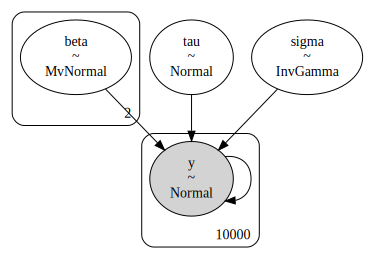

In [7]:
pm.model_to_graphviz(baseline_model)

From the graphical representation, we can see the various model components, their distributions, and how they interact with each other.

We are now ready to **compute** the model posterior. How does it work? In short, we sample realizations of model parameters, we compute the likelihood of the data given those values and the compute the corresponding posterior.

In [8]:
idata = pm.sample(model=baseline_model, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


The fact that Bayesian inference requires sampling, has been historically one of the main bottlenecks of Bayesian statistics, since it makes it sensibly slower than the frequentist approach. However, this is less and less of a problem with the increased computational power of model computers.

We are now ready to print out results. First, with the `summary()` method, we can print a model summary very similar to those produced by the `statsmodels` package.

In [9]:
pm.summary(idata, hdi_prob=0.95).round(4)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.019,0.025,-0.031,0.068,0.001,0.0,1943.0,1866.0,1.0
beta[1],0.992,0.010,0.970,1.011,0.000,0.0,2239.0,1721.0,1.0
tau,0.157,0.021,0.117,0.197,0.000,0.0,2770.0,2248.0,1.0
sigma,0.993,0.007,0.980,1.007,0.000,0.0,3473.0,2525.0,1.0


The estimated parameters are extremely close to the ones we got with the frequentist approach, with an estimated effect of the `infinite_scroll` equal to $0.157$. 

If sampling had the disadvantage of being slow, it has the advantage of being very **transparent**. We can directly plot the distribution of the posterior. Let's do it for the treatment effect $\tau$. The PyMC function `plot_posterior` plots the distribution of the posterior, with a black bar for the Bayesian equivalent of a 95% confidence interval.

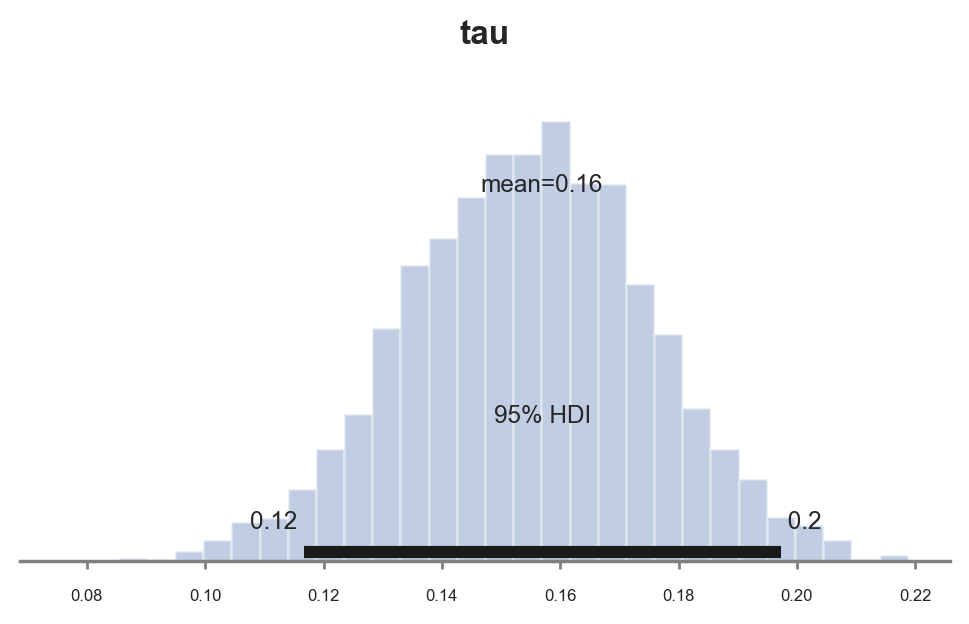

In [10]:
pm.plot_posterior(idata, kind="hist", var_names=('tau'), hdi_prob=0.95, figsize=(6, 3), bins=30); 

As expected, since we chose conjugate priors, the posterior distribution looks gaussian.

So far we have chosen the prior without much guidance. However, suppose we had access to past experiments. How do we incorporate this specific information?

## Past Experiments

Suppose the idea of the infinite scroll, was just one among a ton of other ones that we tried and tested in the past. For each idea we have the data for the corresponding experiment, with the corresponding estimated coefficient. Suppose we had a thousand of them.

In [11]:
past_experiments = [dgp.generate_data(seed_data=i) for i in range(1000)]
taus = [smf.ols('ad_revenue ~ infinite_scroll + past_revenue', pe).fit().params.values for pe in past_experiments]

How do we use this additional information?

### Normal Prior

The first idea could be to calibrate our prior to reflect the data distribution in the past. Keeping the normality assumption, we use the estimated average and standard deviations of the estimates from past experiments.

In [12]:
taus_mean = np.mean(taus, axis=0)[1]
taus_mean

0.0009094486420266667

On average, had practically no effect on `ad_revenue`, with a average effect of $0.0009$.

In [13]:
taus_std = np.sqrt(np.cov(taus, rowvar=0)[1,1])
taus_std

0.029014447772168384

However, there was sensible variation across experiments, with a standard deviation of $0.029$.

Let's now estimate the 

In [14]:
with pm.Model() as model_normal_prior:
    k = np.shape(X)[1]
    beta = pm.MvNormal('beta', mu=np.ones(k), cov=np.eye(k))
    tau = pm.Normal('tau', mu=taus_mean, sigma=taus_std)
    sigma = pm.InverseGamma('sigma', mu=1, sigma=1, initval=1)
    Ylikelihood = pm.Normal('y', mu=(X@beta + D@tau).flatten(), sigma=sigma, observed=y)

Let's sample from the model.

In [15]:
idata_normal_prior = pm.sample(model=model_normal_prior, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


And plot the sample posterior distribution of the treatment effect parameter $\tau$.

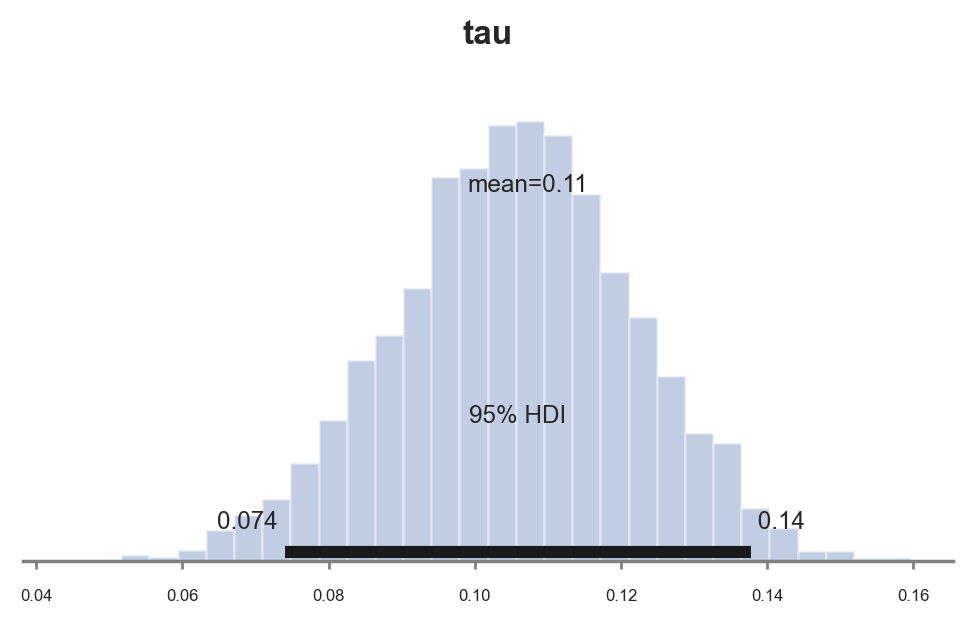

In [16]:
pm.plot_posterior(idata_normal_prior, kind="hist", var_names=('tau'), hdi_prob=0.95, figsize=(6, 3), bins=30); 

The estimated coefficient is sensibly smaller: $0.08$ instead of the previous estimate of $0.12$. Why is it the case?

The fact is that the previous coefficient of $0.12$ is extremely unlikey, given our prior. We can compute the probability of getting the same or a more extreme value, given the prior.

In [17]:
1 - sp.stats.norm(taus_mean, taus_std).cdf(0.12)

2.025724712373389e-05

The probability of such value is almost zero. Therefore, the estimated coefficient has moved towards the prior mean of $0.0009$.

### Student t Prior

So far, we have assumed a normal distribution for all linear coefficients. Is it appropriate? Let's check it visually (check [here](https://medium.com/towards-data-science/how-to-compare-two-or-more-distributions-9b06ee4d30bf) for other methods on how to compare distributions).

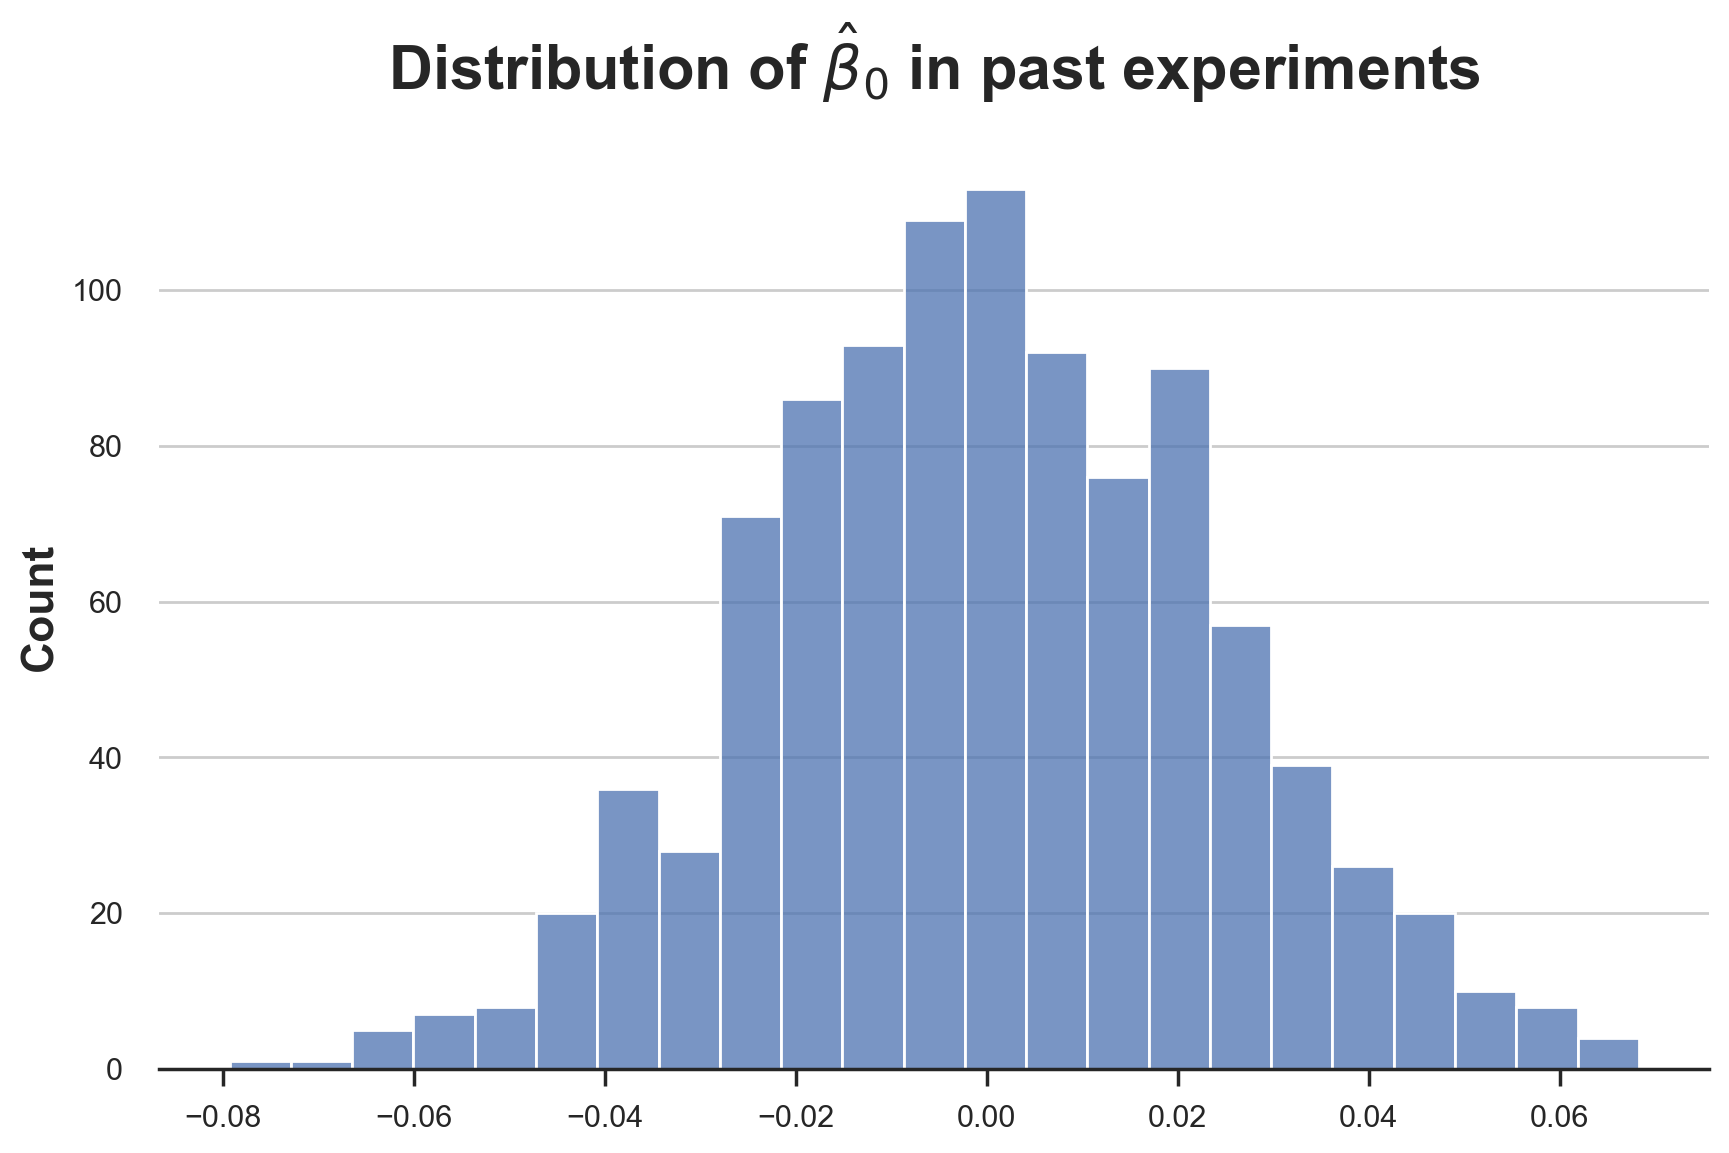

In [18]:
sns.histplot([tau[0] for tau in taus]).set(title=r'Distribution of $\hat{\beta}_0$ in past experiments');

The distribution seems pretty normal. What the treatment effect paramenter $\tau$?

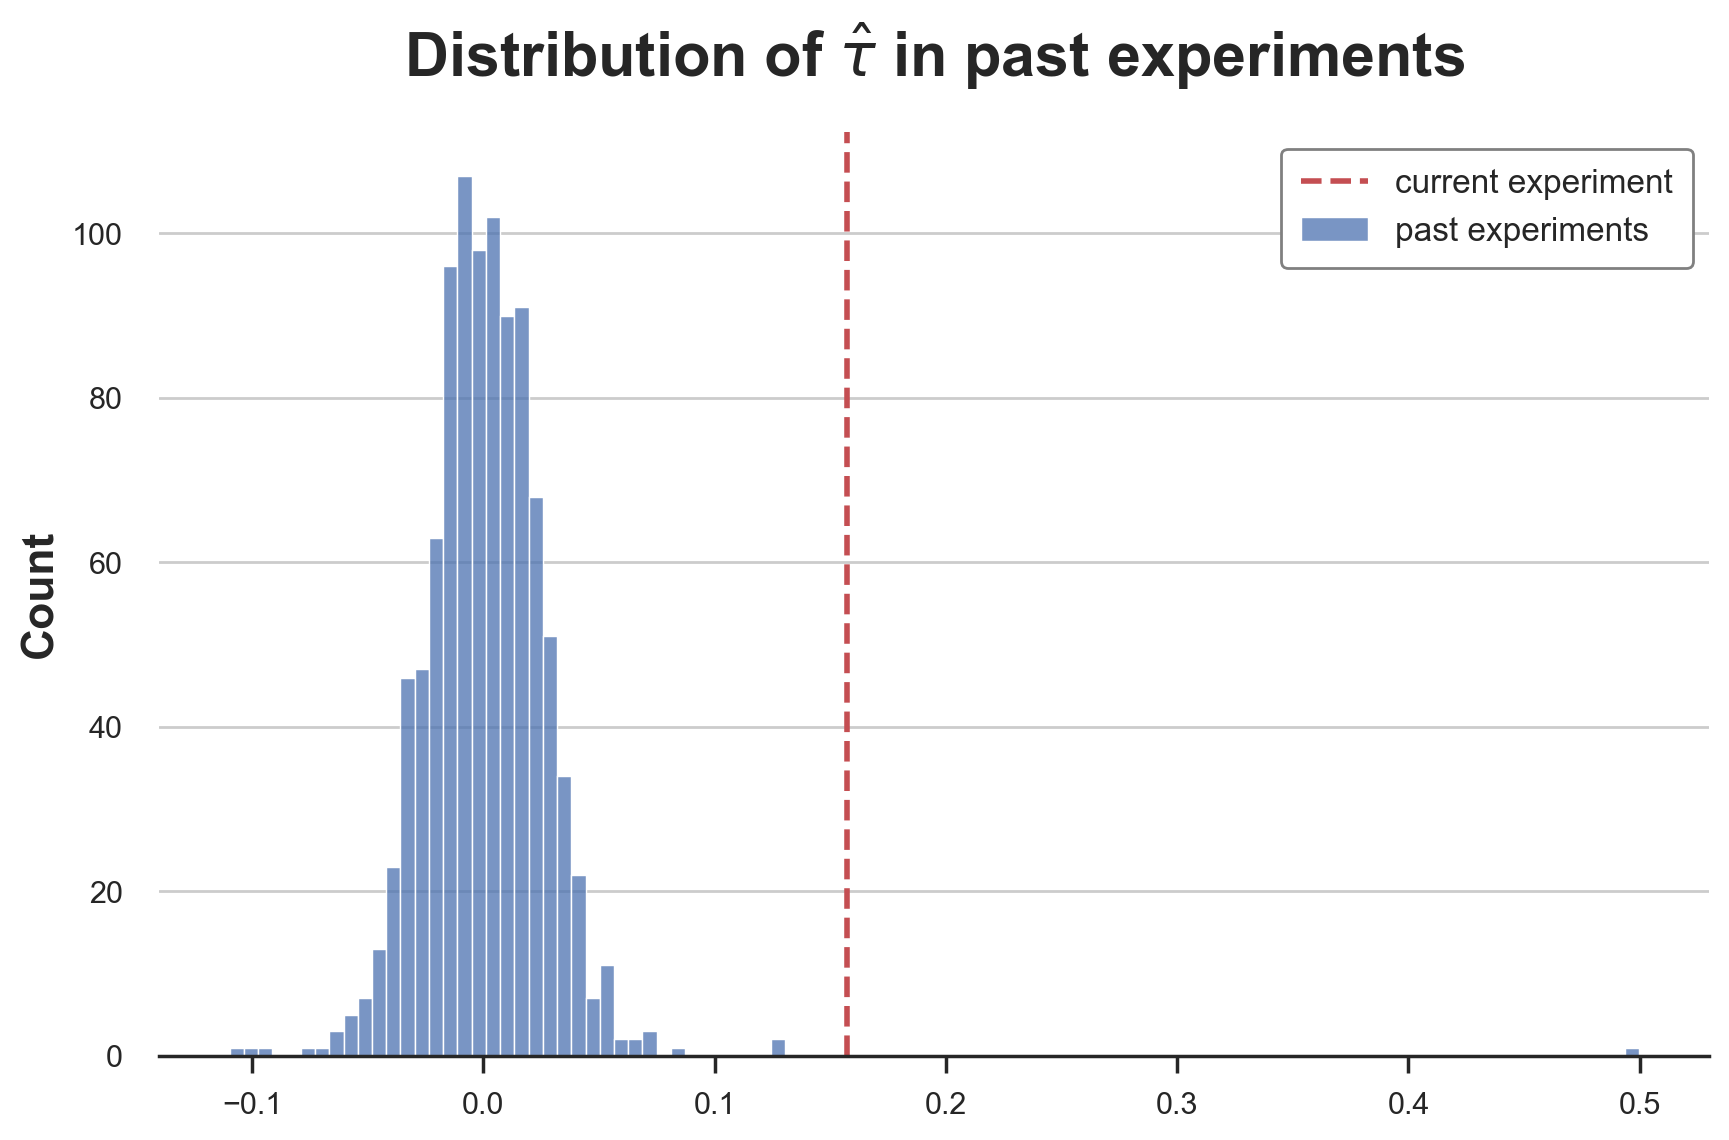

In [19]:
fig, ax = plt.subplots()
sns.histplot([tau[1] for tau in taus], label='past experiments');
ax.axvline(reg.params['infinite_scroll'], lw=2, c='C3', ls='--', label='current experiment')
plt.legend();
plt.title(r'Distribution of $\hat{\tau}$ in past experiments');

The distribution very **heavy tailed**! While at the center it looks like a normal distributions, the tails are much "fatter" and we have a couple of very extreme values. excluding the case of measurement error, this is a setting that happens often in the industry, where most ideas have extremely small or null effects and very rarely an idea is actually a breakthrough. 

One way to model this distribution is a [student-t distribution](). In particular, we use a t-student with mean $0.0009$, variance $0.003$ and $1.3$ degrees of freedom to match the moments of the empirical distributions of past estimates.

In [20]:
with pm.Model() as model_studentt_prior:

    # Priors
    k = np.shape(X)[1]
    beta = pm.MvNormal('beta', mu=np.ones(k), cov=np.eye(k))
    tau = pm.StudentT('tau', mu=taus_mean, sigma=0.003, nu=1.3)
    sigma = pm.InverseGamma('sigma', mu=1, sigma=1, initval=1)
    
    # Likelihood 
    Ylikelihood = pm.Normal('y', mu=(X@beta + D@tau).flatten(), sigma=sigma, observed=y)

Let's sample from the model.

In [21]:
idata_studentt_priors = pm.sample(model=model_studentt_prior, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


And plot the sample posterior distribution of the treatment effect parameter $\tau$.

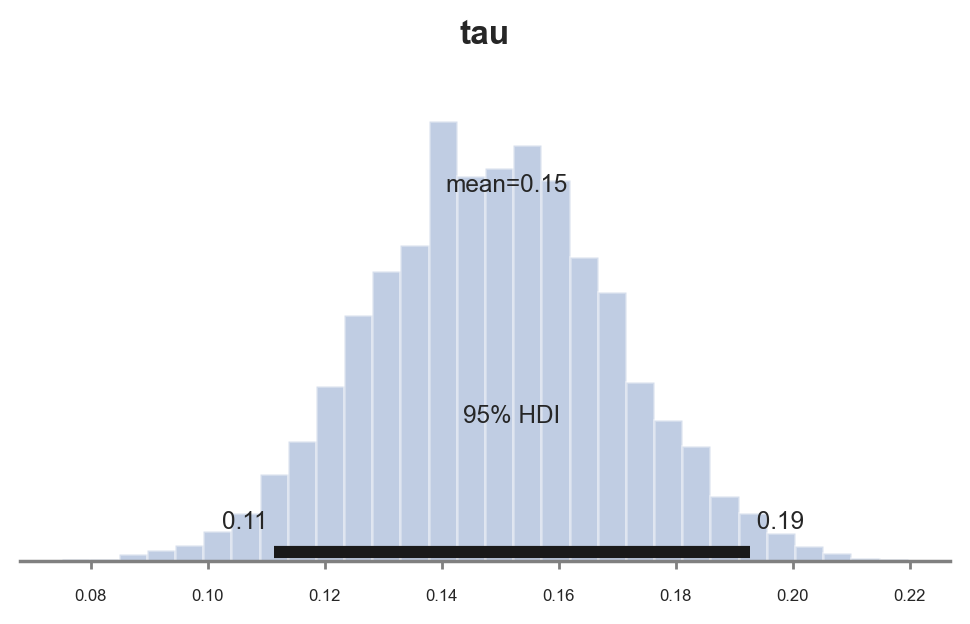

In [22]:
pm.plot_posterior(idata_studentt_priors, kind="hist", var_names=('tau'), hdi_prob=0.95, figsize=(6, 3), bins=30); 

The estimated coefficient is now again similar to the one we got with the standard normal prior, $0.11$. However, the estimate is more precise since the confidence interval has shrunk from $[0.077, 0.016]$ to $[0.065, 0.015]$.

What has happened? 

### Shrinking

The answer lies in the shape of the different **prior distributions** that we have used:

- standard normal, $N(0,1)$
- normal with matched moments, $N(0, 0.03)$
- t-student with matched moments, $t_{1.3}$(0, 0.003)$

In [23]:
t_hats = np.linspace(-0.3, 0.3, 1_000)
distributions = {
    'N(0,1)': sp.stats.norm(0, 1).pdf(t_hats),
    'N(0, 0.03)': sp.stats.norm(0, 0.03).pdf(t_hats),
    '$t_{1.3}$(0, 0.003)': sp.stats.t(df=1.3).pdf(t_hats / 0.003)*300,
}

Let's plot all of them together.

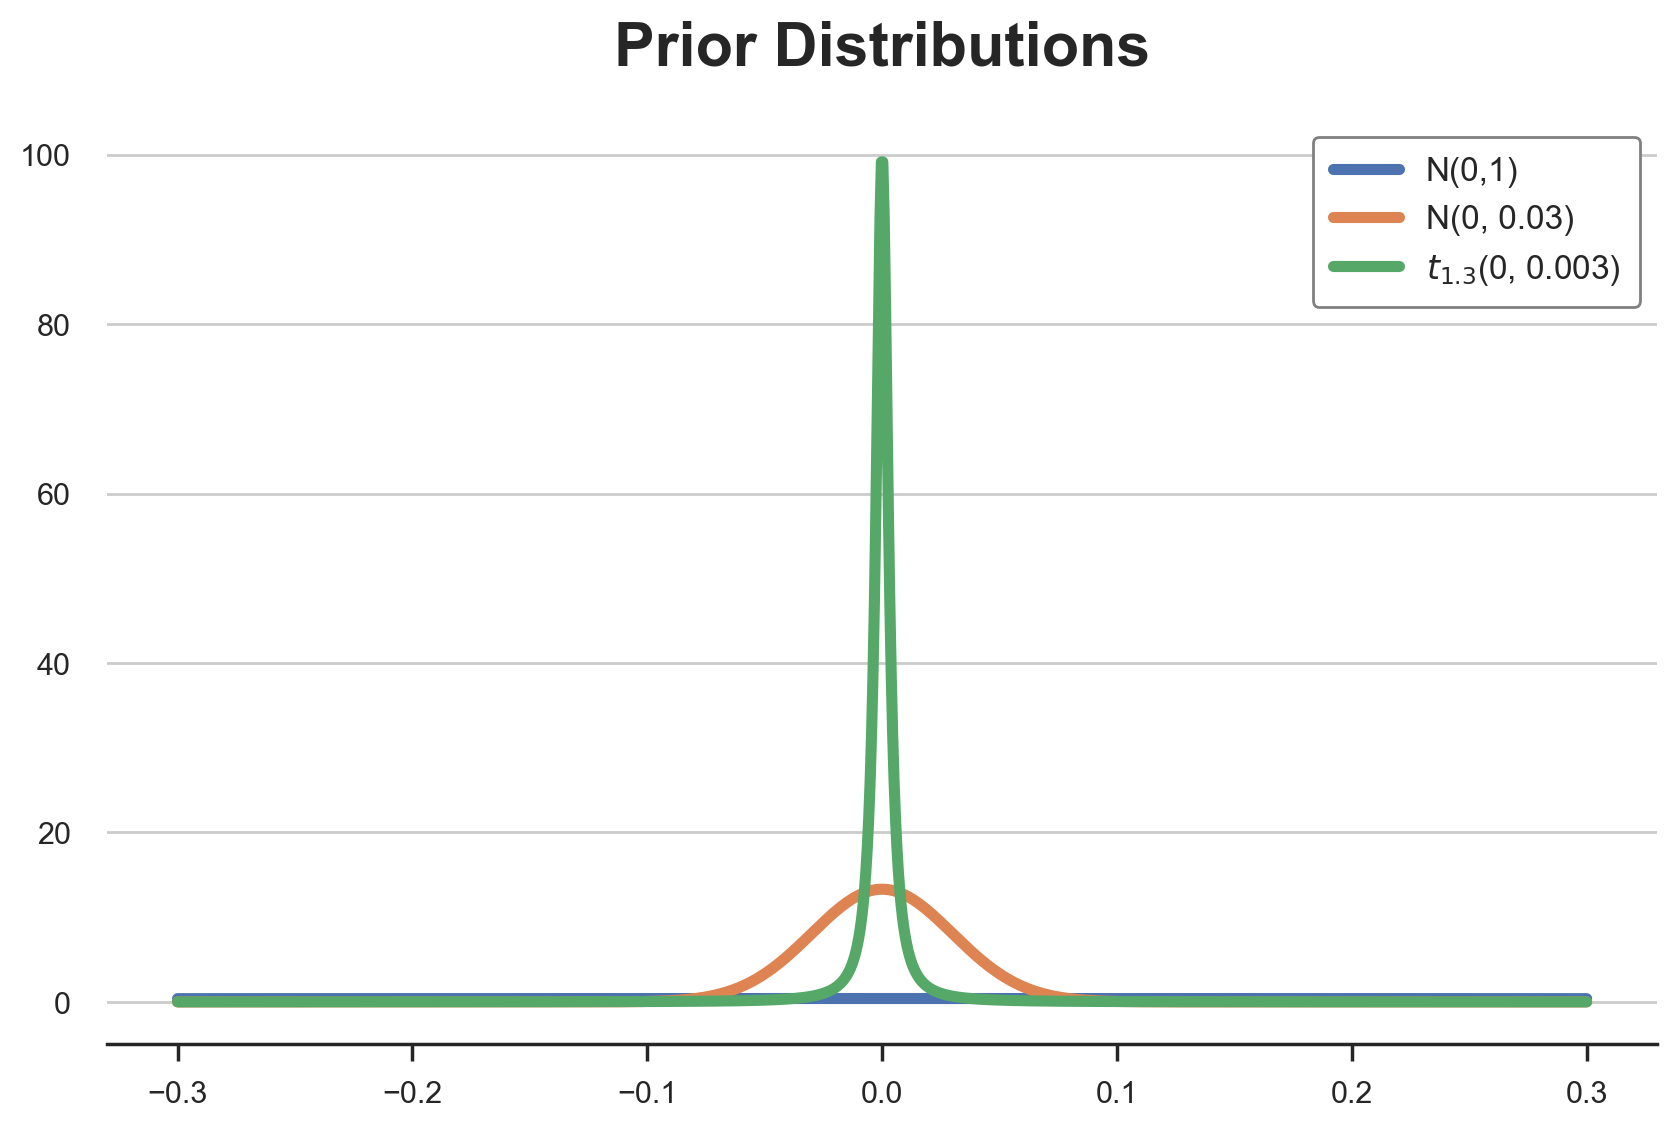

In [24]:
for i, (label, y) in enumerate(distributions.items()):
    sns.lineplot(x=t_hats, y=y, color=f'C{i}', label=label);
plt.legend(); 
plt.title('Prior Distributions');

As we can see, all distributions are centered on zero, but they have very different shapes. The standard normal distribution is essentially flat over the $[-0.15, 0.15]$ interval. Every value has basically the same probability. The last two instead, even though they have the same mean and variance, have very different shapes.

How does it translate into our estimation? We can plot the implied posterior for different estimates, for each prior distribution. 

In [25]:
def compute_posterior(b, prior):
    likelihood = sp.stats.norm(b, taus_std).pdf(t_hats)
    return np.average(t_hats, weights=prior*likelihood)

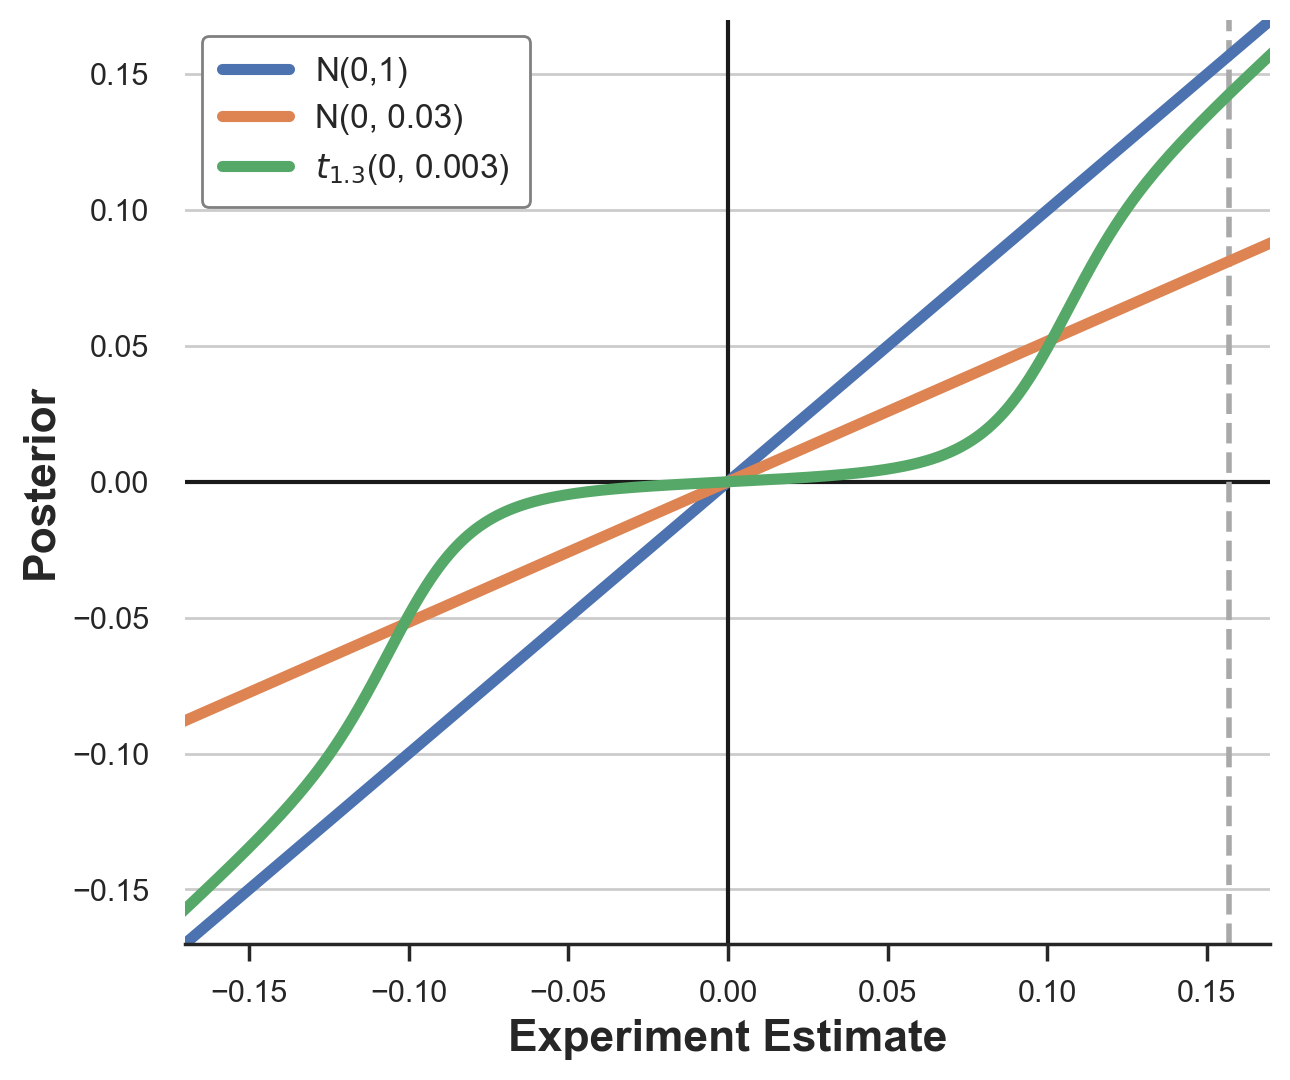

In [26]:
fig, ax = plt.subplots(figsize=(7,6))
ax.axvline(0, lw=1.5, c='k');
ax.axhline(0, lw=1.5, c='k');
ax.axvline(reg.params['infinite_scroll'], lw=2, ls='--', c='darkgray');
for i, (label, y) in enumerate(distributions.items()):
    sns.lineplot(x=t_hats, y=[compute_posterior(t, y) for t in t_hats] , color=f'C{i}', label=label);
ax.set_xlim(-0.17, 0.17);
ax.set_ylim(-0.17, 0.17);
plt.legend(); 
ax.set_xlabel('Experiment Estimate');
ax.set_ylabel('Posterior');

As we can see, the different priors transform the experimental estimates in very different ways. The standard normal prior essentially has no effect for estimates in the $[-0.15, 0.15]$ interval. The normal prior with matched moments instead shrinks each estimate by approximately 2/3. The effect of the t-student prior is instead **non-linear**: it shrinks small estimates towards zero, while it keeps large estimates as they are.

My **intuition** is the following. A prior distribution very skewed or with "fat tails" means that large values are rare but not impossible. In practice, it means accepting that breakthrough improvements are possible. On the other hand, for the same variance, the distribution is more concentrated around zero than a standard normal so that small values are shrunk even more. 

<img src="fig/scroll.jpg" width="300px"/>

## Conclusion

In this article we have seen how to extend the analysis of AB test to incorporate **information from past experiments**. In particular, we have seen the importance of choosing a prior. Selecting the distribution function is just as important as tuning its parameters. The shape of the prior distribution can drastically affect our inference, especially in a world with skewed distributions. 

Despite the length of the article, this was just a glimpse in the world of **AB testing and Bayesian statistics**. While being computationally more intensive and requiring additional assumptions, the Bayesian approach is often more natural, powerful and flexible than the frequentist one. Knowing pros and cons of both approaches is crucial to get the best of both worlds, picking the approach that work best or combining them efficiently.

### References

- E. Azevedo, A. Deng, J. Olea, G. Weyl, [Empirical Bayes Estimation of Treatment Effects with Many A/B Tests: An Overview](https://www.aeaweb.org/articles?id=10.1257/pandp.20191003) (2019). *AEA Papers and Proceedings*.

- A. Deng, [Objective Bayesian Two Sample Hypothesis Testing for Online Controlled Experiments](https://dl.acm.org/doi/abs/10.1145/2740908.2742563) (2018), *WWW15*.

### Related Articles

- [The Bayesian Bootstrap](https://medium.com/towards-data-science/the-bayesian-bootstrap-6ca4a1d45148)

- [Understanding CUPED](https://towardsdatascience.com/understanding-cuped-a822523641af)

- [DAGs and Control Variables](https://towardsdatascience.com/controls-b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/bayes_ab.ipynb